#### Import Libraries

In [1]:
import shutil
import random
import math
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import pandas as pd

2022-11-13 05:58:26.744044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 05:58:29.449913: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 05:58:29.475436: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 05:58:30.015118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

#### Datasets

In [2]:
base_dir = "datasets"

print("Train (Cat):", len(os.listdir(os.path.join(base_dir, "train/cat"))))
print("Train (Dog):", len(os.listdir(os.path.join(base_dir, "train/dog"))))

print("Train after Augmentation (Cat):", len(os.listdir(os.path.join(base_dir, "train_aug/cat"))))
print("Train after Augmentation (Dog):", len(os.listdir(os.path.join(base_dir, "train_aug/dog"))))

print("Val (Cat):", len(os.listdir(os.path.join(base_dir, "val/cat"))))
print("Val (Dog):", len(os.listdir(os.path.join(base_dir, "val/dog"))))

print("Test:", len(os.listdir(os.path.join(base_dir, "test"))))

Train (Cat): 10000
Train (Dog): 10000
Train after Augmentation (Cat): 20000
Train after Augmentation (Dog): 20000
Val (Cat): 2500
Val (Dog): 2500
Test: 500


In [3]:
img_height, img_width = 128, 128
batch_size = 32
train_dir = "./datasets"

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(train_dir, "train_aug"),
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(train_dir, "val"),
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 40000 files belonging to 2 classes.


2022-11-13 05:58:34.205434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 05:58:36.625441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2022-11-13 05:58:36.626950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22290 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-11-13 05:58:36.628110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/t

Found 5000 files belonging to 2 classes.


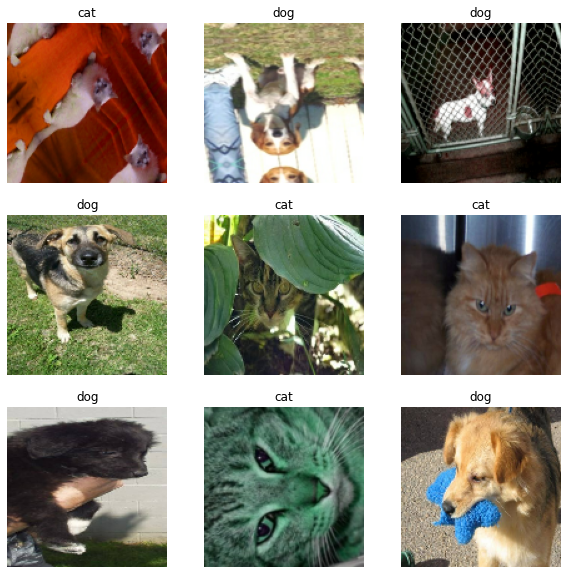

In [4]:
class_names = ["cat", "dog"]
plt.figure(figsize=(10,10))

# get a batch of batch_size
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8")) # displaying image
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### CNN Model 

In [20]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Rescaling(1./255))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)

/media/ntu/volume1/home/s122md302_01/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = EPOCHS,
    callbacks=[earlyStopping]
)

Epoch 1/50
1250/1250 [==============================] - 24s 15ms/step - loss: 0.7027 - accuracy: 0.6075 - val_loss: 0.5514 - val_accuracy: 0.7206
Epoch 2/50
1250/1250 [==============================] - 18s 15ms/step - loss: 0.5865 - accuracy: 0.6836 - val_loss: 0.5325 - val_accuracy: 0.7464
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5342 - accuracy: 0.7246 - val_loss: 0.4058 - val_accuracy: 0.8118
Epoch 4/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4963 - accuracy: 0.7547 - val_loss: 0.3885 - val_accuracy: 0.8256
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4545 - accuracy: 0.7812 - val_loss: 0.5768 - val_accuracy: 0.7142
Epoch 6/50
1250/1250 [==============================] - 20s 15ms/step - loss: 0.4199 - accuracy: 0.8013 - val_loss: 0.4014 - val_accuracy: 0.8022
Epoch 7/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3908 - accuracy: 0.8162 - val_loss: 0.2929 -

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 63, 63, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)       

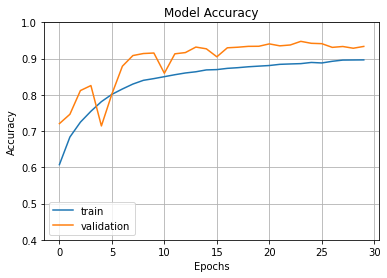

157/157 [==============================] - 2s 11ms/step - loss: 0.1591 - accuracy: 0.9336


[0.15912801027297974, 0.9336000084877014]

In [23]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
model.evaluate(val_ds)

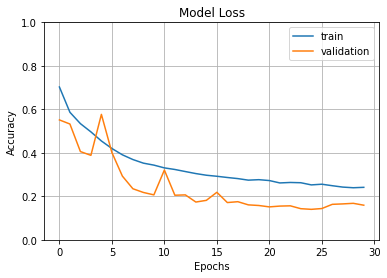

: 

In [24]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

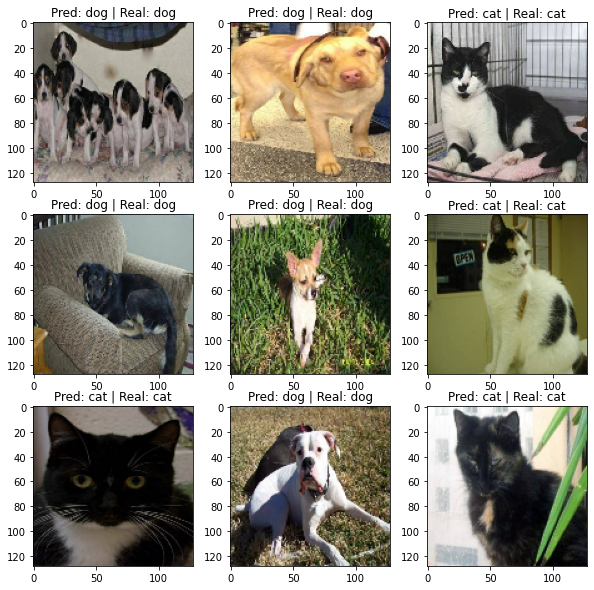

In [95]:
plt.figure(figsize=(10,10))
for images, labels in val_ds.take(1):
    classifications = model(images)
    # print(classifications)

    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = int(np.round(classifications[i])[0])
        plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

#### Saving Output

In [102]:
test_dir = "./datasets/test"

paths = []
ids = []
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        ids.append(filename.split('.')[0])

predictions = []

for path in paths:
    img = tf.keras.preprocessing.image.load_img(path, target_size = (img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    prediction = class_names[int(np.round(model.predict(img))[0][0])]
    predictions.append(prediction)

with open('submission.csv', 'w') as f:
    f.write('id,label\n')
    for id, pred in zip(ids, predictions):
        f.write(f'{id},{pred}\n')

1/1 [==============================] - 0s 27ms/step


In [121]:
# Sorting submission.csv

submission = pd.read_csv('submission.csv')
submission = submission.sort_values(['id'])
submission = submission.set_index('id')
submission.to_csv('submission_sorted.csv')

#### Single Image Tests

1/1 [==============================] - 0s 20ms/step


'dog'

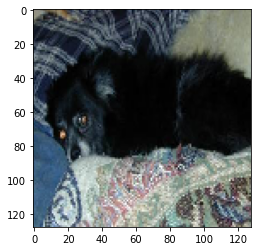

In [88]:
img = tf.keras.preprocessing.image.load_img('./datasets/val/dog/dog.254.jpg', target_size = (img_width, img_height))
plt.imshow(img)
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
class_names[int(np.round(model.predict(img))[0][0])]

#### Saving Model

In [122]:
# Saving
model.save("./SavedModel/gradual_cnn/model")

INFO:tensorflow:Assets written to: ./SavedModel/gradual_cnn/model/assets


INFO:tensorflow:Assets written to: ./SavedModel/gradual_cnn/model/assets


#### Analyzing Wrong Predictions

In [96]:
wrong = []

for c in os.listdir('datasets/val/'):
    for file in os.listdir(os.path.join('datasets/val', c)):
        img0 = tf.keras.preprocessing.image.load_img(os.path.join('datasets/val', c, file), target_size = (img_width, img_height))
        # plt.imshow(img)
        img = tf.keras.preprocessing.image.img_to_array(img0)
        img = np.expand_dims(img, axis = 0)
        if class_names[int(np.round(model.predict(img))[0][0])] != c:
            wrong.append((c, file, class_names[int(np.round(model.predict(img))[0][0])]))

1/1 [==============================] - 0s 36ms/step


In [100]:
wrong_pred = pd.DataFrame(wrong, columns=["Actual", "File", "Predicted"])

In [101]:
wrong_pred.to_csv('wrong_pred.csv')